In [1]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from copy import deepcopy
import scipy.io
import sys
import math
import os
import scipy.interpolate

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
c:\users\joshr\appdata\local\programs\python\python38\lib\site-packages\torch\__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


- Reference data file is loaded
- Variables are separated into individual arrays
- Reynolds and Prandtl numbers are defined

In [2]:
reference_data = np.loadtxt("cylinder_point_source.dat")
x_cell_centroid = reference_data[:, 0]
y_cell_centroid = reference_data[:, 1]
vol_weights = reference_data[:, 3]
u_mean_x = reference_data[:, 4]
u_mean_y = reference_data[:, 5]
t_mean = reference_data[:, 6]
div_uprime2_mean_x = reference_data[:, 10]
div_uprime2_mean_y = reference_data[:, 11]
g_mean = reference_data[:, 14]
Re = 150
Pr = 266.8

Converting unstructured data into structured uniform grid:
- provide unstructured coordinates and the relevant data
- provide grid of desired structured coordinates
- creates individual arrays of interpolated structured data for each quantity to use instead of unstructured data

In [3]:
points = np.zeros((len(x_cell_centroid), 2))
for i in range(len(x_cell_centroid)):
    points[i][0] = x_cell_centroid[i]
    points[i][1] = y_cell_centroid[i]

# integer before 'j' = (number of points in x or y) + 1    
    
grid_x, grid_y = np.mgrid[-14.9167:39.9:660j, -9.95:9.95:240j]
num_x = np.shape(grid_x)[0]
num_y = np.shape(grid_y)[1]

gridu = scipy.interpolate.griddata(points, u_mean_x, (grid_x, grid_y)).T
gridv = scipy.interpolate.griddata(points, u_mean_y, (grid_x, grid_y)).T
gridt = scipy.interpolate.griddata(points, t_mean, (grid_x, grid_y)).T

# now need to generate new x and y points using linspace

x_line = np.linspace(-14.9167, 39.9, num_x)
y_line = np.linspace(-9.95, 9.95, num_y)
    
# reformat new_grid u data to be same shape as x and y

current_y = np.zeros(num_x)
new_x = []
new_y = []
new_u = []
new_v = []
new_t = []
for i in range(num_y):
    for j in range(num_x):
        current_y[j] = y_line[i]
    new_y = np.concatenate((new_y, current_y))
    new_x = np.concatenate((new_x, x_line))
    new_u = np.concatenate((new_u, gridu[i]))
    new_v = np.concatenate((new_v, gridv[i]))
    new_t = np.concatenate((new_t, gridt[i]))

new_x = np.array(new_x)
new_y = np.array(new_y)
new_u = np.array(new_u)
new_v = np.array(new_v)
new_t = np.array(new_t)

- PINN computational domain defined (smaller than dataset domain)
- computational geometry defined as rectangular domain with a cylinder hole of radius 0.5 at (0,0)
- number of prediction points in x and y defined for later (150 points per unit)

In [4]:
vertex_botleft = [-3, -4]
vertex_topright = [15, 4]
geom = dde.geometry.Rectangle(vertex_botleft, vertex_topright) - dde.geometry.Disk([0, 0], 0.5)
figsize = (16, 12)

Nx = int((vertex_topright[0]-vertex_botleft[0])*100)+1
Ny = int((vertex_topright[1]-vertex_botleft[1])*100)+1

Define PDEs function: Continuity equation, 2D RANS equations with divergence-free solenoidal forcing, and scalar transport equation
- define output matrix of quantities V
- define first and second order partial derivatives from automatic differentiation
- return PDE equations for PINN to solve

In [5]:
def pde(X, V):
    # put quantities into arrays of single-value arrays
    u = V[:, 0:1]
    v = V[:, 1:2]
    p = V[:, 2:3]
    t = V[:, 3:4]
    fx = V[:, 4:5]
    fy = V[:, 5:6]
    g = V[:, 6:7]
    
    # compute partial derivatives. components i, j: i is the component from the V matrix (0 - 6 for respective properties),
    # j is component for spatial coordinate (0 - 1 for x or y)
    du_x = dde.grad.jacobian(V, X, i=0, j=0)
    dv_y = dde.grad.jacobian(V, X, i=1, j=1)
    du_y = dde.grad.jacobian(V, X, i=0, j=1)
    dv_x = dde.grad.jacobian(V, X, i=1, j=0)
    dp_x = dde.grad.jacobian(V, X, i=2, j=0)
    dp_y = dde.grad.jacobian(V, X, i=2, j=1)
    dt_x = dde.grad.jacobian(V, X, i=3, j=0)
    dt_y = dde.grad.jacobian(V, X, i=3, j=1)
    # compute partial second derivatives. First parameter is variable rather than matrix.
    # i, j are denominator spatial coordinate indices, e.g dy/dxidxj
    du_xx = dde.grad.hessian(u, X, i=0, j=0)
    dv_xx = dde.grad.hessian(v, X, i=0, j=0)
    du_yy = dde.grad.hessian(u, X, i=1, j=1)
    dv_yy = dde.grad.hessian(v, X, i=1, j=1)
    dt_xx = dde.grad.hessian(t, X, i=0, j=0)
    dt_yy = dde.grad.hessian(t, X, i=1, j=1)
    # compute partial derivatives of forcing term
    dfx_x = dde.grad.jacobian(V, X, i=4, j=0)
    dfy_y = dde.grad.jacobian(V, X, i=5, j=1)
    
    return [
        du_x + dv_y,
        u * du_x + v * du_y + dp_x - (1.0 / Re) * (du_xx + du_yy) + fx,
        u * dv_x + v * dv_y + dp_y - (1.0 / Re) * (dv_xx + dv_yy) + fy,
        dfx_x + dfy_y, 
        u * dt_x + v * dt_y - (1.0 / (Re * Pr)) * (dt_xx + dt_yy) + g
    ]

Function to generate PINN-friendly training points from the reference data

In [6]:
def generate_training_points(x, y, u, v, t):
    x_t = []
    y_t = []
    u_t = []
    v_t = []
    t_t = []
    
    x_t = np.array(x_t)
    y_t = np.array(y_t)
    u_t = np.array(u_t)
    v_t = np.array(v_t)
    t_t = np.array(t_t)
    
    x_t = x[0::1].reshape(-1, 1)
    y_t = y[0::1].reshape(-1, 1)
    u_t = u[0::1].reshape(-1, 1)
    v_t = v[0::1].reshape(-1, 1)
    t_t = t[0::1].reshape(-1, 1)
    
    X = []
    
    for i in range(x_t.shape[0]):
        if geom.inside([x_t[i, 0], y_t[i, 0]]) \
                and x_t[i, 0] > vertex_botleft[0] and x_t[i, 0] < vertex_topright[0] \
                and y_t[i, 0] > vertex_botleft[1] and y_t[i, 0] < vertex_topright[1]:
            X.append([x_t[i, 0], y_t[i, 0], u_t[i, 0], v_t[i, 0], t_t[i, 0]])
    
    X = np.array(X)
 
    return np.hsplit(X, 5)

Function to plot data and collocation points after the network is created before proceeding to training

In [7]:
def plot_training_points(data, bc_ranges, bc_labels, title, figsize):
    plt.figure(figsize=figsize)
    plt.title(f"Training points for {title}")
    plt.scatter(
        data.train_x[np.sum(data.num_bcs):, 0],
        data.train_x[np.sum(data.num_bcs):, 1],
        label="Freestream collocation points", s=1.2
    )
    bc_ranges = [0] + bc_ranges
    print('BC ranges', bc_ranges)
    print('Num bcs', data.num_bcs)
    for i in range(1, 3):
        plt.scatter(
            data.train_x[
                int(np.sum(data.num_bcs[: bc_ranges[i - 1]])): np.sum(
                    data.num_bcs[: bc_ranges[i]]
                ),
                0,
            ],
            data.train_x[
                int(np.sum(data.num_bcs[: bc_ranges[i - 1]])): np.sum(
                    data.num_bcs[: bc_ranges[i]]
                ),
                1,
            ],
            label=bc_labels[i - 1], s=1.5,
        )
    plt.legend(loc=(1.05, 0.45))
    plt.xlabel("x/c")
    plt.ylabel("y/c")
    axes= plt.gca()
    axes.set_aspect(1)
    plt.tight_layout()
    plt.show()
    plt.close()

Generate and plot data points within the PINN's computational domain

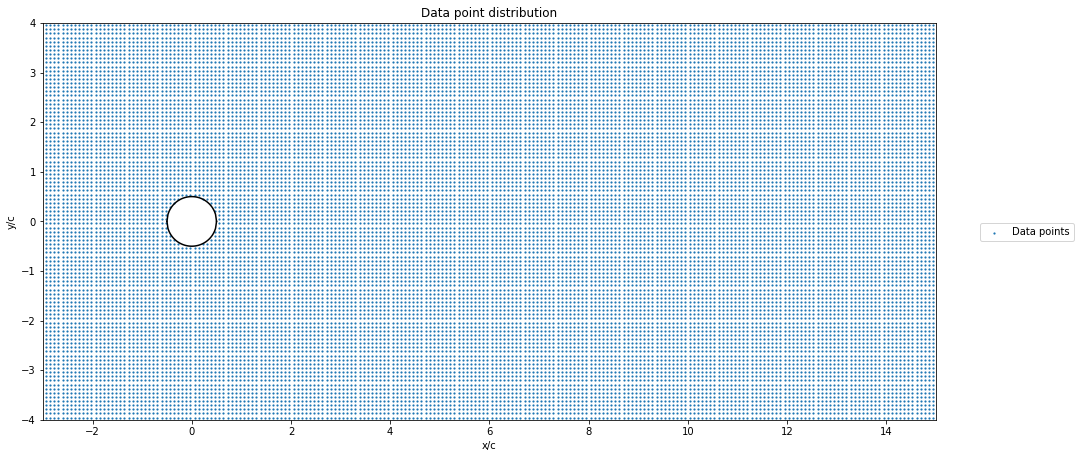

20620 training points in domain


In [8]:
[x_training, y_training, u_training, v_training, t_training] = \
    generate_training_points(new_x, new_y, new_u, new_v, new_t)

training_points = np.hstack((x_training, y_training))

tx = []
ty = []
for i in range(0, len(training_points)):
    tx.append(training_points[i][0])
    ty.append(training_points[i][1])
    
cylinderx = np.linspace(-0.5, 0.5, 50)
cylindery = np.sqrt(0.5**2 - cylinderx**2)
plt.figure(figsize=figsize)
plt.scatter(tx, ty, s=1.4, label="Data points")
plt.plot(cylinderx, cylindery, color='k')
plt.plot(cylinderx, -cylindery, color='k')
axes = plt.gca()
axes.set_aspect(1)
axes.set_xlim([-3.0, 15.0])
axes.set_ylim([-4.0, 4.0])
axes.set_title("Data point distribution")
plt.xlabel("x/c")
plt.ylabel("y/c")
plt.legend(loc=(1.05, 0.45))
plt.show()
plt.close()
print(str(len(training_points)) + " training points in domain")

Define boundary conditions for PDEs:
- define zeros function (0 at all points)
- define ones function (1 at all points)
- define function for cylinder wall coordinates
- defines domain boundary conditions for freestream data points
- defines wall boundary conditions at cylinder wall (no-slip, etc)

In [9]:
def func_zeros(X):
    x = X[:, 0:1]
    return x * 0

def boundary(x, on_boundary):
    return on_boundary and not(
        np.isclose(x[0], vertex_botleft[0]) or np.isclose(x[0], vertex_topright[0]) 
        or np.isclose(x[1], vertex_botleft[1]) or np.isclose(x[1], vertex_topright[1])
    )

# u, v dirichlet BCs at each point in training_points
u_training_points = dde.PointSetBC(training_points, u_training, component=0)
v_training_points = dde.PointSetBC(training_points, v_training, component=1)
t_training_points = dde.PointSetBC(training_points, t_training, component=3)
# dirichlet BCs at walls, component indices from pde function
bc_wall_u = dde.DirichletBC(geom, func_zeros, boundary, component=0)
bc_wall_v = dde.DirichletBC(geom, func_zeros, boundary, component=1)
bc_wall_t = dde.NeumannBC(geom, func_zeros, boundary, component=3)
bc_wall_fx = dde.DirichletBC(geom, func_zeros, boundary, component=4)
bc_wall_fy = dde.DirichletBC(geom, func_zeros, boundary, component=5)
bc_wall_g = dde.NeumannBC(geom, func_zeros, boundary, component=6)

Create PINN:
- create computational problem using already defined geometry, PDEs and boundary conditions
- define number of collocation points
- Plot collocation and data points in PINN domain
- define network size, activation and initializer functions
- create PINN model using problem and network

BC ranges [0, 6, 9]
Num bcs [1279, 1279, 1279, 1279, 1279, 1279, 20620, 20620, 20620]


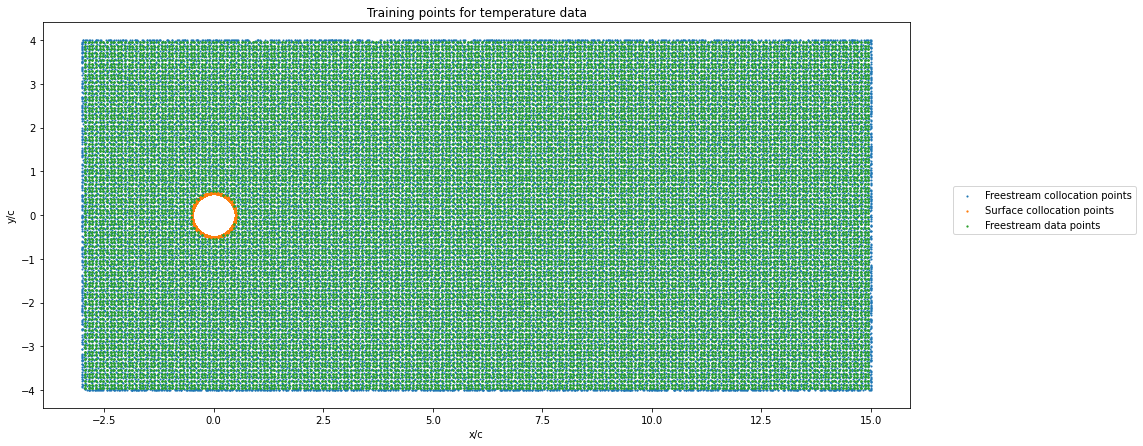

In [10]:
data = dde.data.PDE(
    geom, pde, 
    [bc_wall_u, bc_wall_v, bc_wall_t, bc_wall_fx, bc_wall_fy, bc_wall_g, u_training_points, v_training_points, t_training_points], 
    35000, 2500, solution=None, num_test=10, 
)

plot_training_points(data, [6, 9], ["Surface collocation points", "Freestream data points"],
                    title="temperature data", figsize=figsize)

layer_size = [2] + [100] * 7 + [7]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

- define loss weights array
- compile model and perform first training phase using Adam optimiser

In [11]:
loss_weights = [1, 1, 1, 1, 1, 10, 10, 10, 10, 10, 10, 10, 10, 10]
model.compile("adam", lr=0.001, loss_weights=loss_weights)

losshistory, train_state = model.train(4000, display_every=500)

Compiling model...
'compile' took 0.656616 s

Training model...

Step      Train loss                                                                                                                                      Test loss                                                                                                                                       Test metric
0         [1.85e-02, 2.39e-02, 1.27e-01, 3.62e-03, 7.93e-02, 8.44e-02, 1.36e-01, 6.63e-03, 7.61e-03, 6.28e-02, 3.07e-02, 1.40e+01, 2.62e+00, 7.24e-01]    [2.14e-02, 3.10e-02, 1.09e-01, 7.83e-03, 8.09e-02, 8.44e-02, 1.36e-01, 6.63e-03, 7.61e-03, 6.28e-02, 3.07e-02, 1.40e+01, 2.62e+00, 7.24e-01]    []  
500       [2.15e-02, 1.84e-03, 4.97e-04, 2.13e-04, 6.18e-04, 1.28e-02, 4.46e-03, 3.37e-03, 8.23e-05, 3.25e-05, 3.99e-05, 7.61e-02, 1.28e-02, 4.97e-01]    [4.48e-04, 4.41e-04, 6.13e-04, 7.90e-05, 2.37e-04, 1.28e-02, 4.46e-03, 3.37e-03, 8.23e-05, 3.25e-05, 3.99e-05, 7.61e-02, 1.28e-02, 4.97e-01]    []  


KeyboardInterrupt: 

- recompile model and perform second training phase using L-BFGS-B optimiser

In [ ]:
model.compile("L-BFGS-B", loss_weights=loss_weights)
dde.optimizers.config.set_LBFGS_options(maxiter=16000)
losshistory, train_state = model.train()

- plot training and testing losses throughout training
- save model to folder

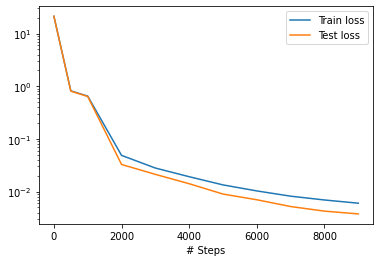

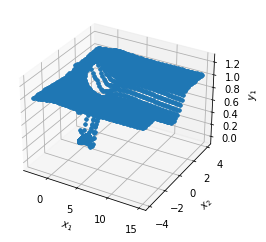

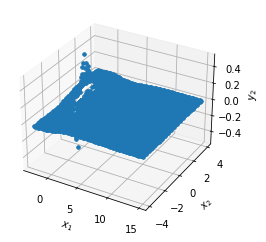

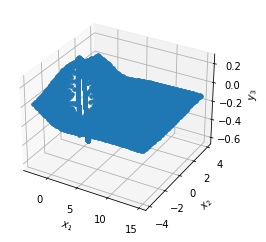

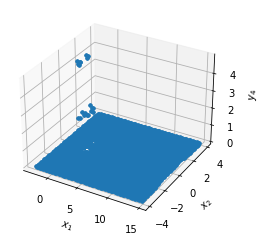

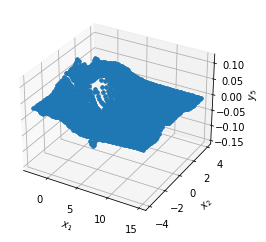

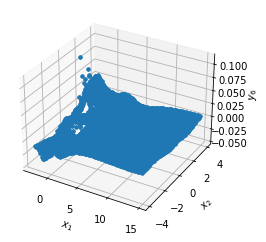

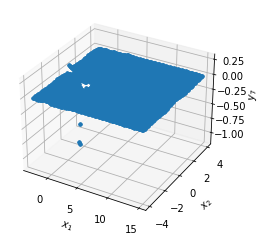

'models/model-bfgs-last-9000.pt'

In [14]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)
model.save("models/model-bfgs-last")

- restore saved model from folder
- produce pcolor plots of predictions for all quantities

Compiling model...
'compile' took 0.001457 s

Compiling model...
'compile' took 0.000435 s



<ipython-input-17-2374d8494267>:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, u_star_data)


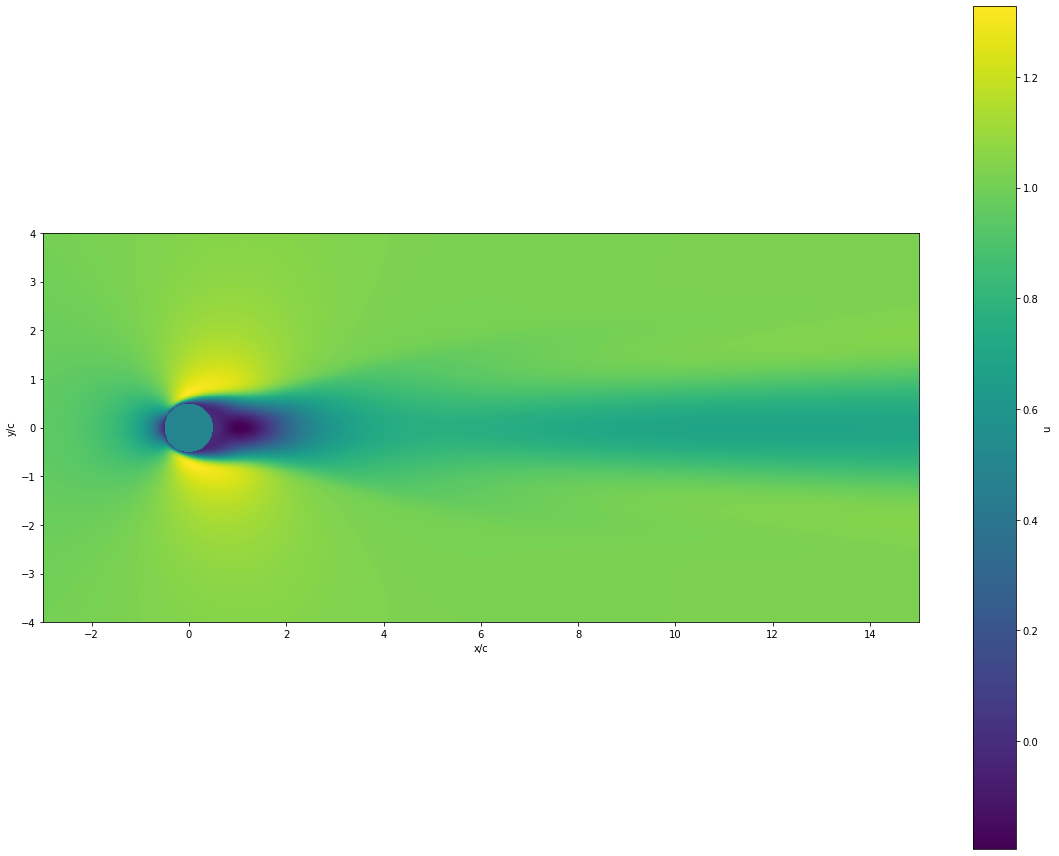

<ipython-input-17-2374d8494267>:67: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, v_star_data)


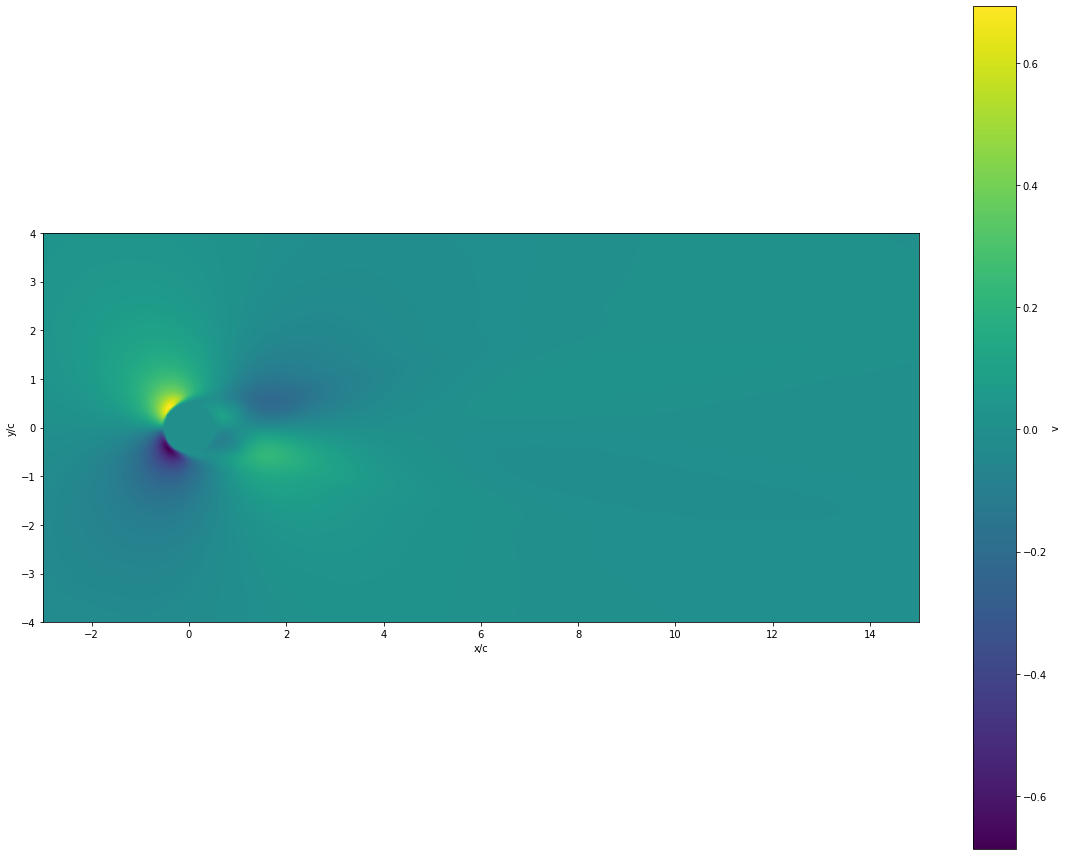

<ipython-input-17-2374d8494267>:79: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, p_star_data+2)


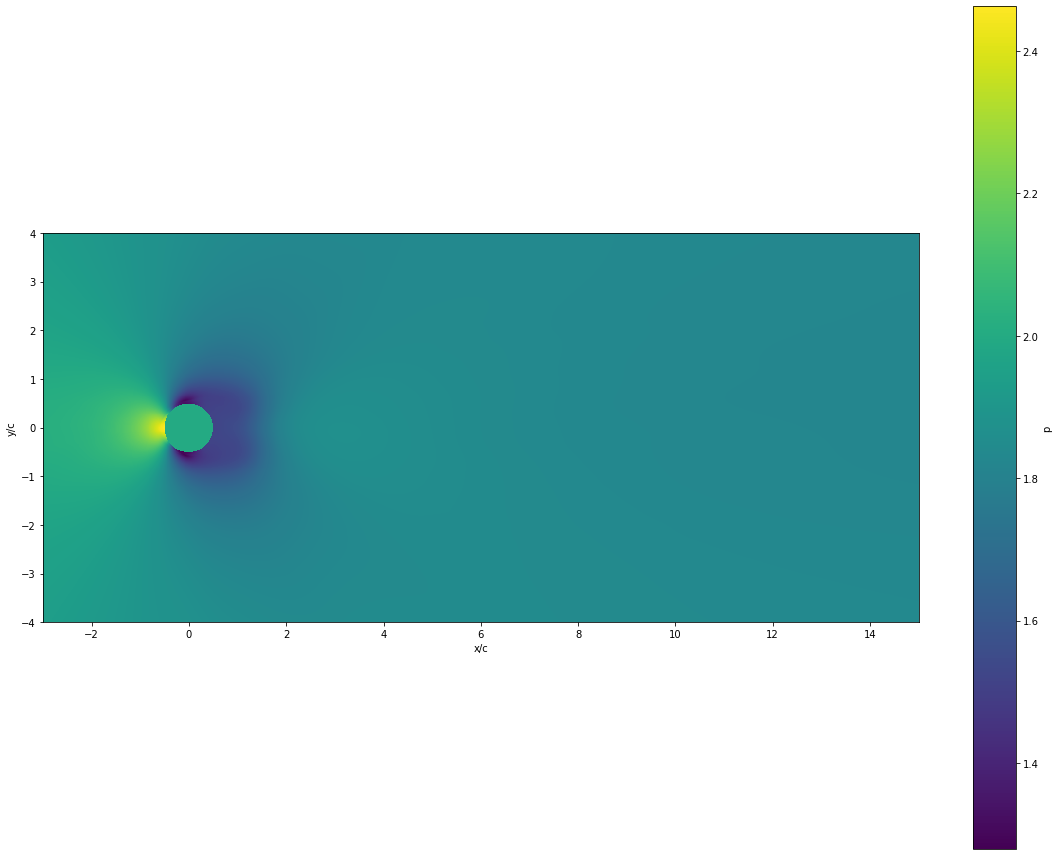

<ipython-input-17-2374d8494267>:91: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, t_star_data)


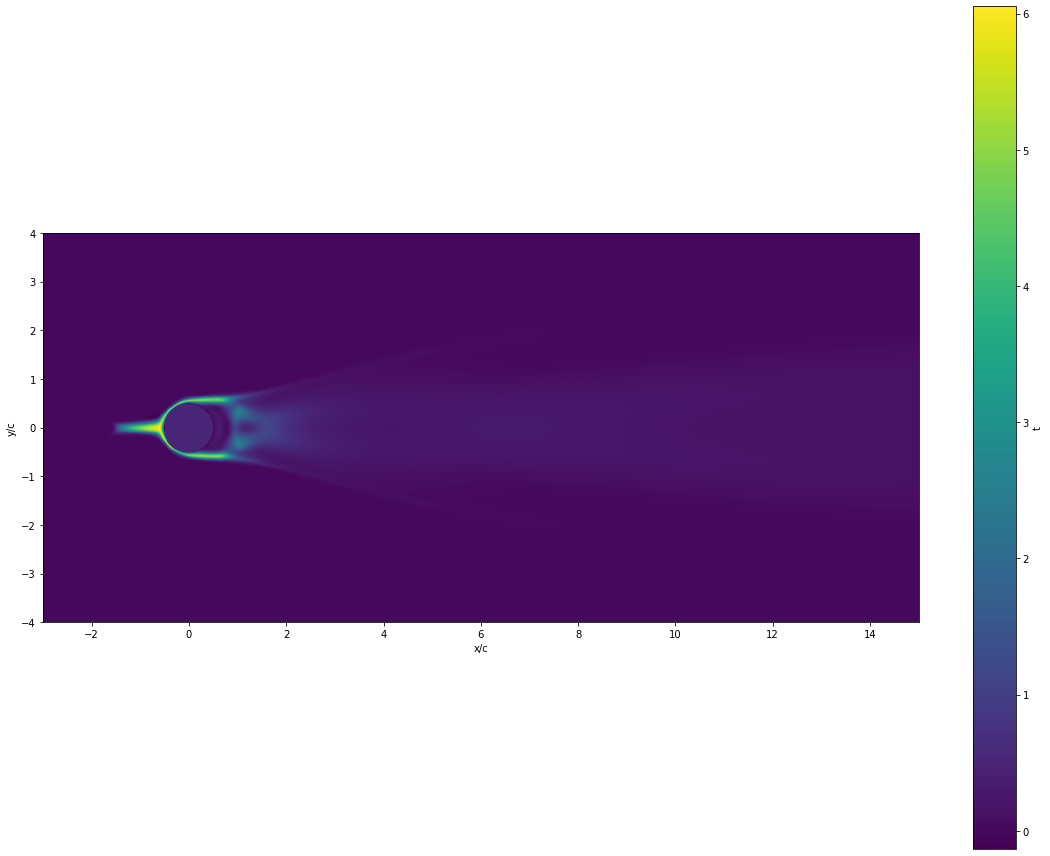

<ipython-input-17-2374d8494267>:103: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, fx_star_data)


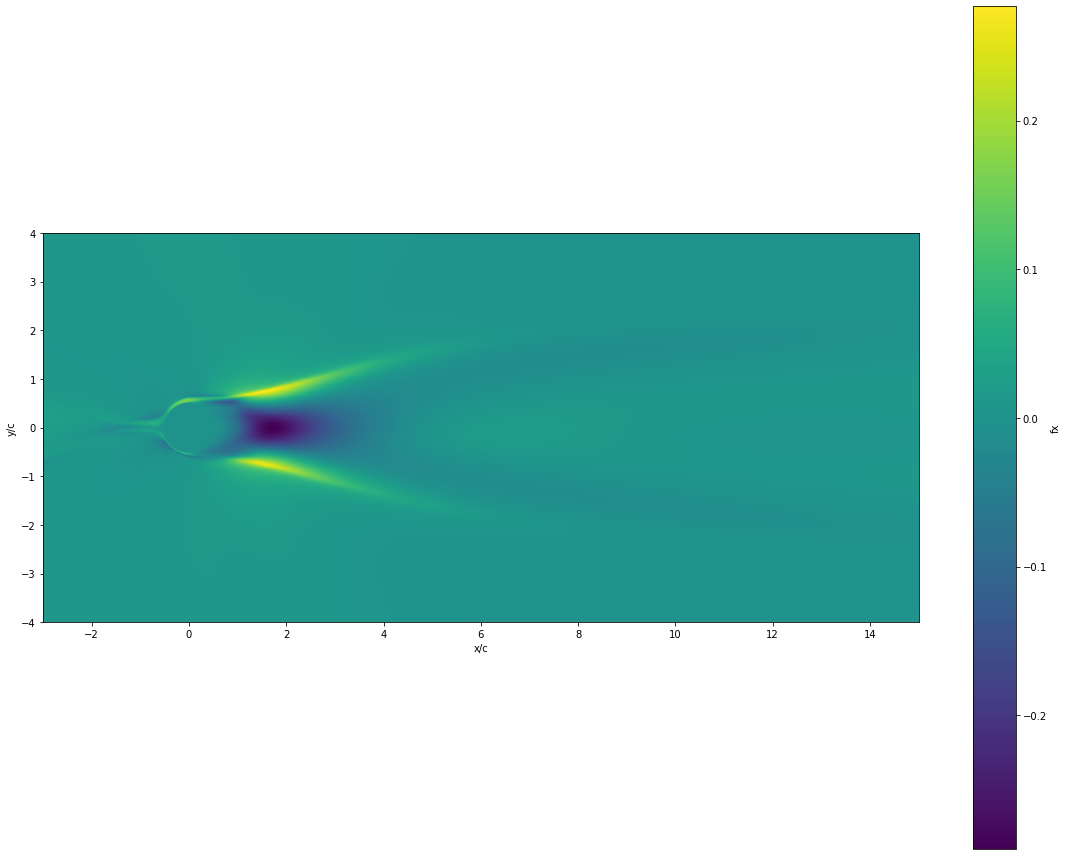

<ipython-input-17-2374d8494267>:115: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, fy_star_data)


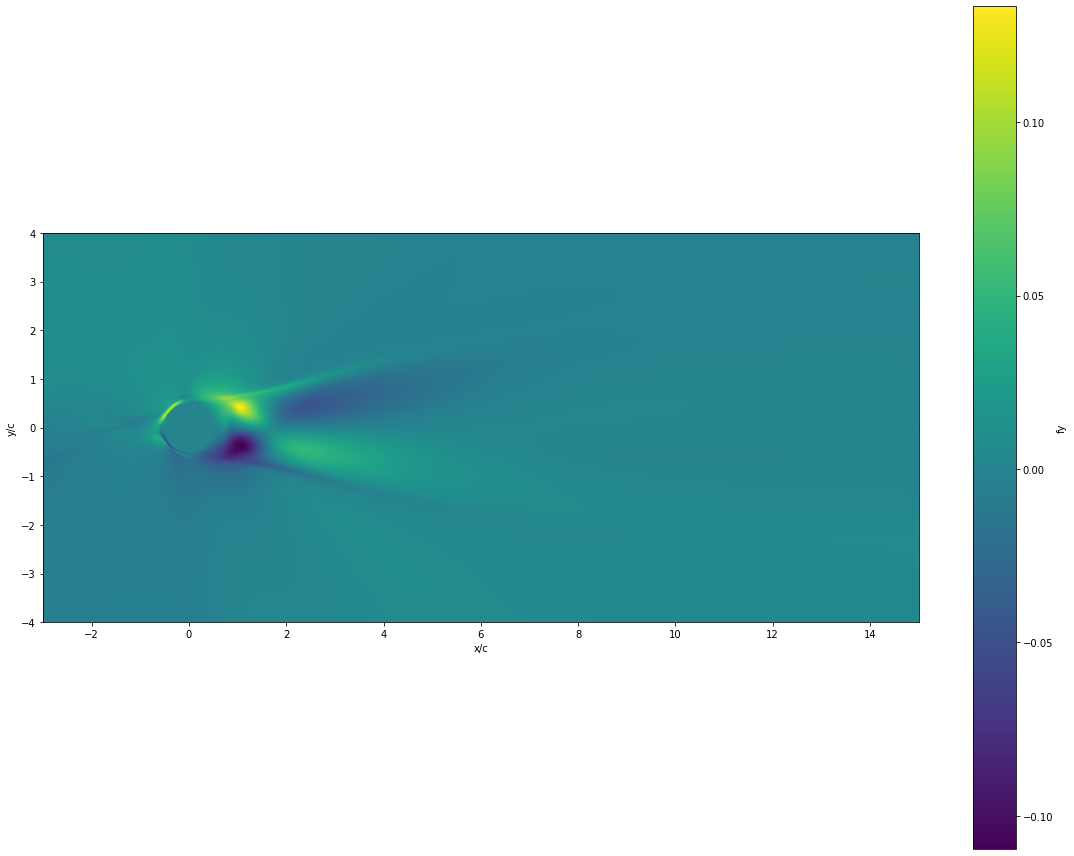

<ipython-input-17-2374d8494267>:127: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, g_star_data)


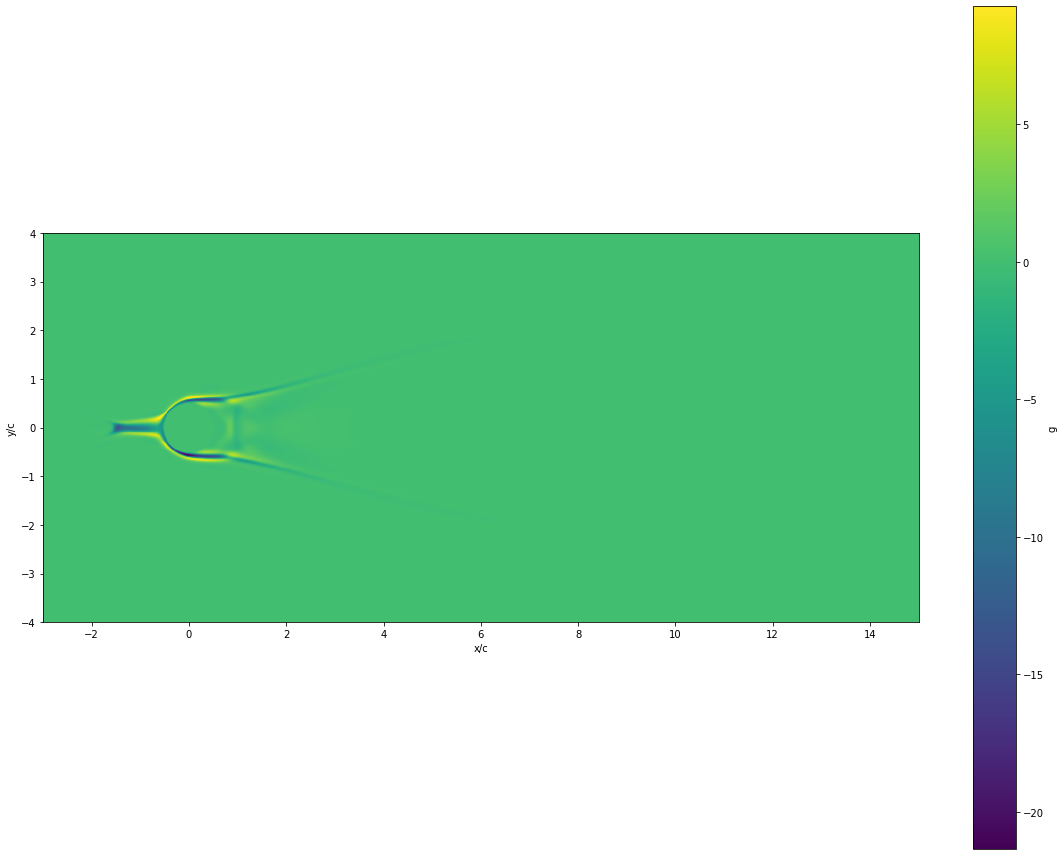

In [17]:
model.compile("adam", lr=0.001)
model.compile("L-BFGS-B")
model.restore("models/440-160BC-34000.pt")

x_plot = np.linspace(vertex_botleft[0], vertex_topright[0], Nx)
y_plot = np.linspace(vertex_botleft[1], vertex_topright[1], Ny)

# define prediction points
z = np.array([np.array([i, j]) for i in x_plot for j in y_plot])

# predict fields
y = model.predict(z)
u_star = y[:, 0][:, None]
v_star = y[:, 1][:, None]
p_star = y[:, 2][:, None]
t_star = y[:, 3][:, None]
fx_star = y[:, 4][:, None]
fy_star = y[:, 5][:, None]
g_star = y[:, 6][:, None]

u_star_data = deepcopy(u_star)
v_star_data = deepcopy(v_star)
p_star_data = deepcopy(p_star)
t_star_data = deepcopy(t_star)
fx_star_data = deepcopy(fx_star)
fy_star_data = deepcopy(fy_star)
g_star_data = deepcopy(g_star)

# remove inside points
bad_indices = []
for i in range(len(z)):
    if(np.sqrt(z[i][0]**2 + z[i][1]**2) < 0.5):
        bad_indices.append(i)
        
for i in range(len(bad_indices)):
    u_star_data[bad_indices[i]][0] = 0.5
    v_star_data[bad_indices[i]][0] = 0
    p_star_data[bad_indices[i]][0] = 0
    t_star_data[bad_indices[i]][0] = 0.5
    fx_star_data[bad_indices[i]][0] = 0
    fy_star_data[bad_indices[i]][0] = 0
    g_star_data[bad_indices[i]][0] = 0
    
u_star_data = u_star_data.reshape(Nx, Ny).T
v_star_data = v_star_data.reshape(Nx, Ny).T
p_star_data = p_star_data.reshape(Nx, Ny).T
t_star_data = t_star_data.reshape(Nx, Ny).T
fx_star_data = fx_star_data.reshape(Nx, Ny).T
fy_star_data = fy_star_data.reshape(Nx, Ny).T
g_star_data = g_star_data.reshape(Nx, Ny).T

# u field prediction plot
X, Y = np.meshgrid(x_plot, y_plot)
plt.figure(figsize=figsize)
plt.pcolor(X, Y, u_star_data)
plt.colorbar(label='u')
plt.xlabel('x/c')
plt.ylabel('y/c')
axes = plt.gca()
axes.set_aspect(1)
plt.tight_layout()
plt.show()
plt.close()

# v field prediction plot
plt.figure(figsize=figsize)
plt.pcolor(X, Y, v_star_data)
plt.colorbar(label='v')
plt.xlabel('x/c')
plt.ylabel('y/c')
axes = plt.gca()
axes.set_aspect(1)
plt.tight_layout()
plt.show()
plt.close()

# p field prediction plot
plt.figure(figsize=figsize)
plt.pcolor(X, Y, p_star_data+2)
plt.colorbar(label='p')
plt.xlabel('x/c')
plt.ylabel('y/c')
axes = plt.gca()
axes.set_aspect(1)
plt.tight_layout()
plt.show()
plt.close()

# t field prediction plot
plt.figure(figsize=figsize)
plt.pcolor(X, Y, t_star_data)
plt.colorbar(label='t')
plt.xlabel('x/c')
plt.ylabel('y/c')
axes = plt.gca()
axes.set_aspect(1)
plt.tight_layout()
plt.show()
plt.close()

# fx field prediction plot
plt.figure(figsize=figsize)
plt.pcolor(X, Y, fx_star_data)
plt.colorbar(label='fx')
plt.xlabel('x/c')
plt.ylabel('y/c')
axes = plt.gca()
axes.set_aspect(1)
plt.tight_layout()
plt.show()
plt.close()

# fy field prediction plot
plt.figure(figsize=figsize)
plt.pcolor(X, Y, fy_star_data)
plt.colorbar(label='fy')
plt.xlabel('x/c')
plt.ylabel('y/c')
axes = plt.gca()
axes.set_aspect(1)
plt.tight_layout()
plt.show()
plt.close()

# g field prediction plot
plt.figure(figsize=figsize)
plt.pcolor(X, Y, g_star_data)
plt.colorbar(label='g')
plt.xlabel('x/c')
plt.ylabel('y/c')
axes = plt.gca()
axes.set_aspect(1)
plt.tight_layout()
plt.show()
plt.close()

- restore saved model from folder
- produce seismic contour plots of predictions for all quantities

Compiling model...
'compile' took 0.001441 s

Compiling model...
'compile' took 0.000390 s



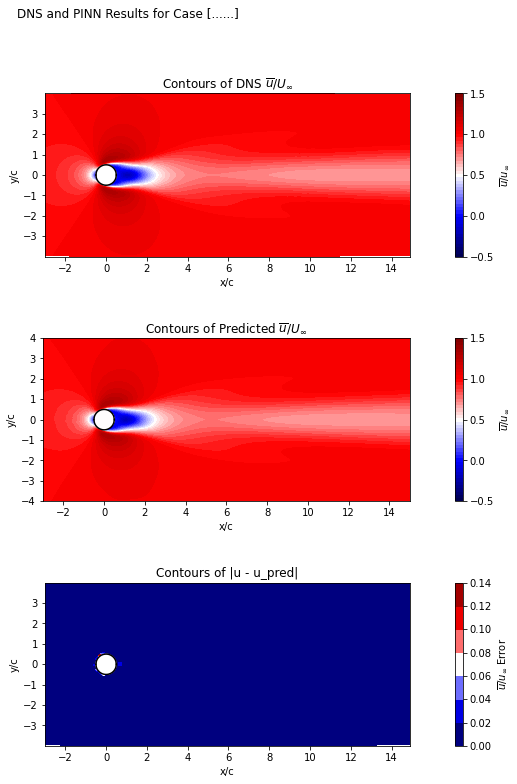

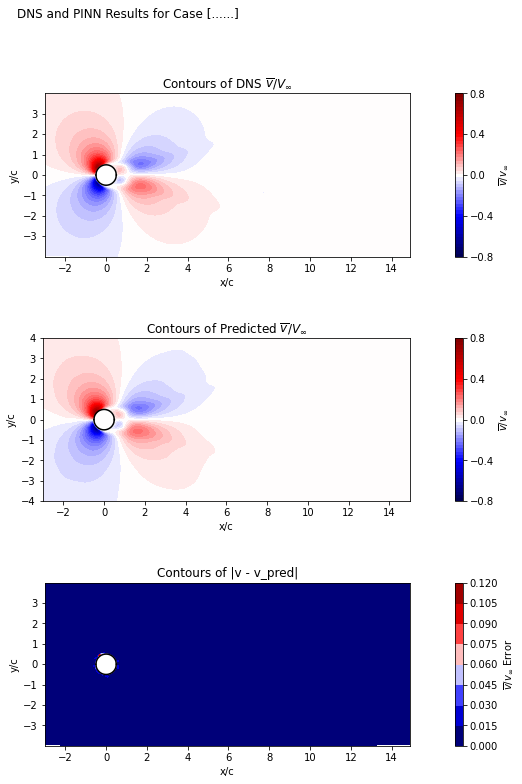

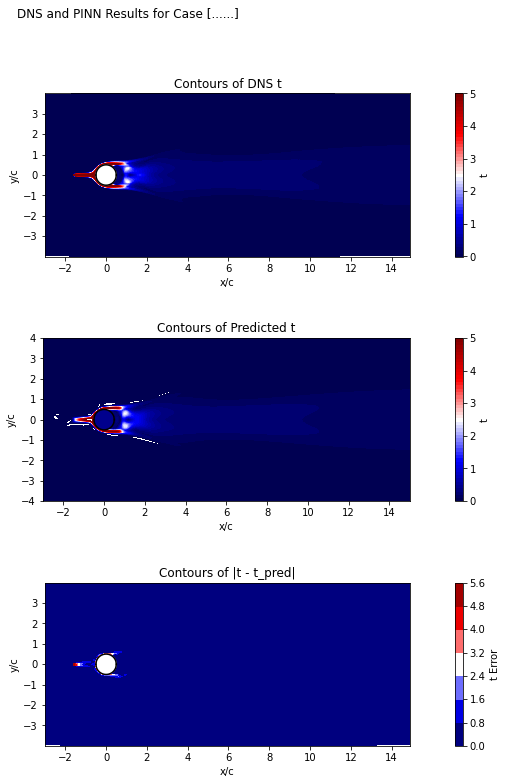

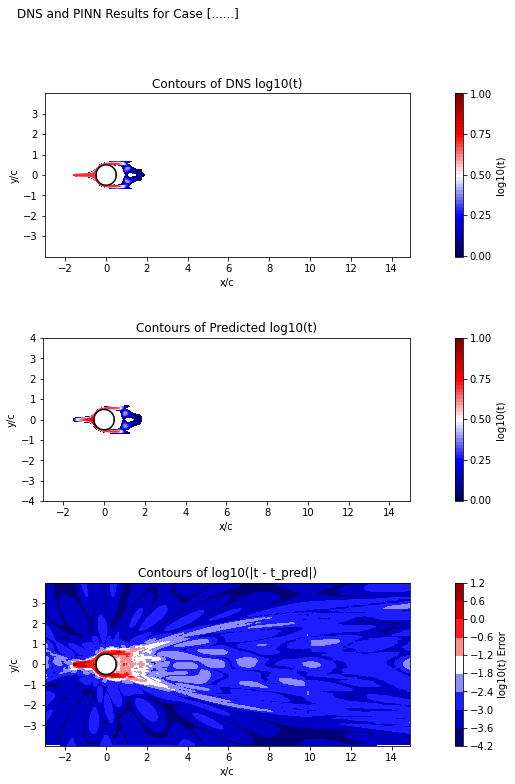

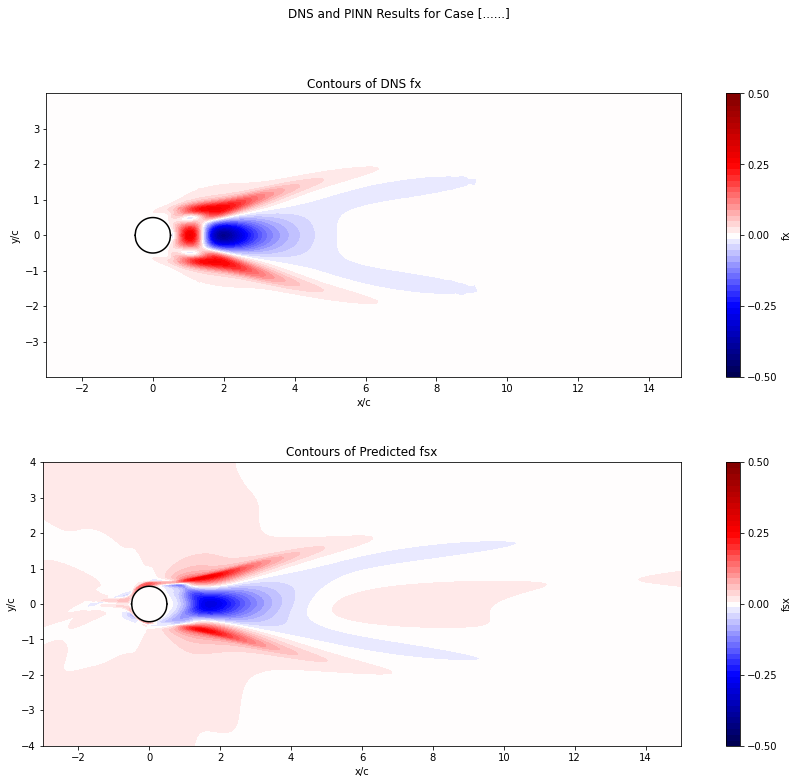

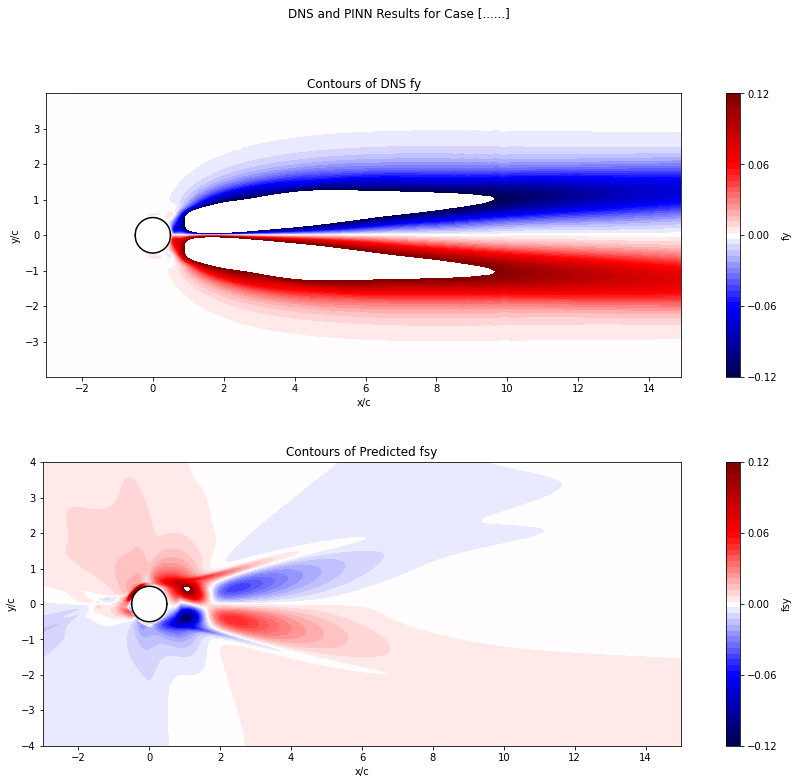

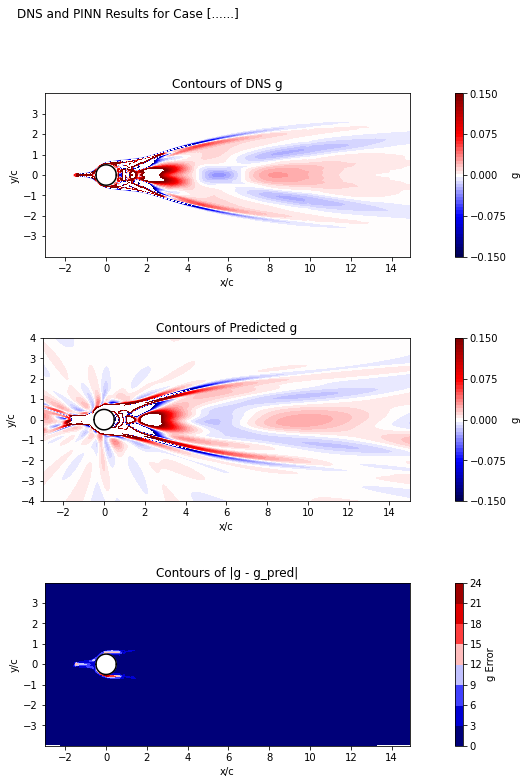

In [18]:
model.compile("adam", lr=0.001)
model.compile("L-BFGS-B")
model.restore("models/440-160BC-34000.pt")

[x_full, y_full, u_full, v_full, t_full] = \
    generate_training_points(x_cell_centroid, y_cell_centroid, u_mean_x, u_mean_y, t_mean)

[x_full, y_full, fx_full, fy_full, g_full] = \
    generate_training_points(x_cell_centroid, y_cell_centroid, div_uprime2_mean_x, div_uprime2_mean_y, g_mean)

full_points = np.hstack((x_full, y_full))

y = model.predict(full_points)
u_star = y[:, 0][:, None]
v_star = y[:, 1][:, None]
p_star = y[:, 2][:, None]
t_star = y[:, 3][:, None]
fx_star = y[:, 4][:, None]
fy_star = y[:, 5][:, None]
g_star = y[:, 6][:, None]

dns_x = np.array(x_full).flatten('F')
dns_y = np.array(y_full).flatten('F')
dns_u = np.array(u_full).flatten('F')
dns_v = np.array(v_full).flatten('F')
dns_t = np.array(t_full).flatten('F')
dns_fx = np.array(fx_full).flatten('F')
dns_fy = np.array(fy_full).flatten('F')
dns_g = np.array(g_full).flatten('F')

u_err = np.zeros(len(full_points))
v_err = np.zeros(len(full_points))
t_err = np.zeros(len(full_points))
fx_err = np.zeros(len(full_points))
fy_err = np.zeros(len(full_points))
g_err = np.zeros(len(full_points))

for i in range(len(full_points)):
    u_err[i] = np.abs(u_full[i] - u_star[i])
    v_err[i] = np.abs(v_full[i] - v_star[i])
    t_err[i] = np.abs(t_full[i] - t_star[i])
    fx_err[i] = np.abs(fx_full[i] - fx_star[i])
    fy_err[i] = np.abs(fy_full[i] - fy_star[i])
    g_err[i] = np.abs(g_full[i] - g_star[i])

cylinderx = np.linspace(-0.5, 0.5, 50)
cylindery = np.sqrt(0.5**2 - cylinderx**2)

cyl1 = plt.Circle((0, 0), 0.5, color='white')
cyl2 = plt.Circle((0, 0), 0.5, color='white')
levels = np.linspace(-0.5, 1.5, 50)
fig, (ax2, ax1, ax3) = plt.subplots(3, 1, figsize=figsize)
ax1.contourf(X, Y, u_star_data, levels, cmap="seismic")
ax1.plot(cylinderx, cylindery, color='k')
ax1.plot(cylinderx, -cylindery, color='k')
ax1.set_aspect(1)
ax1.set_title("Contours of Predicted $\overline{u}/U_\infty$")
ax1.set_xlabel("x/c")
ax1.set_ylabel("y/c")
ax2.tricontourf(dns_x, dns_y, dns_u, levels, cmap="seismic")
ax2.plot(cylinderx, cylindery, color='k')
ax2.plot(cylinderx, -cylindery, color='k')
ax2.set_aspect(1)
ax2.set_title("Contours of DNS $\overline{u}/U_\infty$")
ax2.set_xlabel("x/c")
ax2.set_ylabel("y/c")
ax2.add_patch(cyl1)
ax3.tricontourf(dns_x, dns_y, u_err, cmap="seismic")
ax3.plot(cylinderx, cylindery, color='k')
ax3.plot(cylinderx, -cylindery, color='k')
ax3.set_aspect(1)
ax3.set_title("Contours of |u - u_pred|")
ax3.set_xlabel("x/c")
ax3.set_ylabel("y/c")
ax3.add_patch(cyl2)
contour1 = ax1.contourf(X, Y, u_star_data, levels, cmap="seismic")
contour2 = ax2.tricontourf(dns_x, dns_y, dns_u, levels, cmap="seismic")
contour3 = ax3.tricontourf(dns_x, dns_y, u_err, cmap="seismic")
plt.colorbar(mappable=contour1, shrink=1.0, ticks=[-0.5, 0, 0.5, 1.0, 1.5], label="$\\overline{u}/u_\infty$", ax=ax1)
plt.colorbar(mappable=contour2, shrink=1.0, ticks=[-0.5, 0, 0.5, 1.0, 1.5], label="$\\overline{u}/u_\infty$", ax=ax2)
plt.colorbar(mappable=contour3, shrink=1.0, label="$\\overline{u}/u_\infty$ Error", ax=ax3)
fig.subplots_adjust(hspace=0.5)
fig.suptitle("DNS and PINN Results for Case [......]")
plt.show()
plt.close()

cyl1 = plt.Circle((0, 0), 0.5, color='white')
cyl2 = plt.Circle((0, 0), 0.5, color='white')
levels = np.linspace(-0.8, 0.8, 50)
fig, (ax2, ax1, ax3) = plt.subplots(3, 1, figsize=figsize)
ax1.contourf(X, Y, v_star_data, levels, cmap="seismic")
ax1.plot(cylinderx, cylindery, color='k')
ax1.plot(cylinderx, -cylindery, color='k')
ax1.set_aspect(1)
ax1.set_title("Contours of Predicted $\overline{v}/V_\infty$")
ax1.set_xlabel("x/c")
ax1.set_ylabel("y/c")
ax2.tricontourf(dns_x, dns_y, dns_v, levels, cmap="seismic")
ax2.plot(cylinderx, cylindery, color='k')
ax2.plot(cylinderx, -cylindery, color='k')
ax2.set_aspect(1)
ax2.set_title("Contours of DNS $\overline{v}/V_\infty$")
ax2.set_xlabel("x/c")
ax2.set_ylabel("y/c")
ax2.add_patch(cyl1)
ax3.tricontourf(dns_x, dns_y, v_err, cmap="seismic")
ax3.plot(cylinderx, cylindery, color='k')
ax3.plot(cylinderx, -cylindery, color='k')
ax3.set_aspect(1)
ax3.set_title("Contours of |v - v_pred|")
ax3.set_xlabel("x/c")
ax3.set_ylabel("y/c")
ax3.add_patch(cyl2)
contour1 = ax1.contourf(X, Y, v_star_data, levels, cmap="seismic")
contour2 = ax2.tricontourf(dns_x, dns_y, dns_v, levels, cmap="seismic")
contour3 = ax3.tricontourf(dns_x, dns_y, v_err, cmap="seismic")
plt.colorbar(mappable=contour1, shrink=1.0, ticks=[-0.8, -0.4, 0, 0.4, 0.8], label="$\\overline{v}/v_\infty$", ax=ax1)
plt.colorbar(mappable=contour2, shrink=1.0, ticks=[-0.8, -0.4, 0, 0.4, 0.8], label="$\\overline{v}/v_\infty$", ax=ax2)
plt.colorbar(mappable=contour3, shrink=1.0, label="$\\overline{v}/v_\infty$ Error", ax=ax3)
fig.subplots_adjust(hspace=0.5)
fig.suptitle("DNS and PINN Results for Case [......]")
plt.show()
plt.close()

cyl1 = plt.Circle((0, 0), 0.5, color='white')
cyl2 = plt.Circle((0, 0), 0.5, color='white')
levels = np.linspace(-0.005, 5.0, 50)
fig, (ax2, ax1, ax3) = plt.subplots(3, 1, figsize=figsize)
ax1.contourf(X, Y, t_star_data, levels, cmap="seismic")
ax1.plot(cylinderx, cylindery, color='k')
ax1.plot(cylinderx, -cylindery, color='k')
ax1.set_aspect(1)
ax1.set_title("Contours of Predicted t")
ax1.set_xlabel("x/c")
ax1.set_ylabel("y/c")
ax2.tricontourf(dns_x, dns_y, dns_t, levels, cmap="seismic")
ax2.plot(cylinderx, cylindery, color='k')
ax2.plot(cylinderx, -cylindery, color='k')
ax2.set_aspect(1)
ax2.set_title("Contours of DNS t")
ax2.set_xlabel("x/c")
ax2.set_ylabel("y/c")
ax2.add_patch(cyl1)
ax3.tricontourf(dns_x, dns_y, t_err, cmap="seismic")
ax3.plot(cylinderx, cylindery, color='k')
ax3.plot(cylinderx, -cylindery, color='k')
ax3.set_aspect(1)
ax3.set_title("Contours of |t - t_pred|")
ax3.set_xlabel("x/c")
ax3.set_ylabel("y/c")
ax3.add_patch(cyl2)
contour1 = ax1.contourf(X, Y, t_star_data, levels, cmap="seismic")
contour2 = ax2.tricontourf(dns_x, dns_y, dns_t, levels, cmap="seismic")
contour3 = ax3.tricontourf(dns_x, dns_y, t_err, cmap="seismic")
plt.colorbar(mappable=contour1, shrink=1.0, ticks=[0, 1, 2, 3, 4, 5], label="t", ax=ax1)
plt.colorbar(mappable=contour2, shrink=1.0, ticks=[0, 1, 2, 3, 4, 5], label="t", ax=ax2)
plt.colorbar(mappable=contour3, shrink=1.0, label="t Error", ax=ax3)
fig.subplots_adjust(hspace=0.5)
fig.suptitle("DNS and PINN Results for Case [......]")
plt.show()
plt.close()

cyl1 = plt.Circle((0, 0), 0.5, color='white')
cyl2 = plt.Circle((0, 0), 0.5, color='white')
levels = np.linspace(-0.005, 1.0, 50)
fig, (ax2, ax1, ax3) = plt.subplots(3, 1, figsize=figsize)
ax1.contourf(X, Y, np.log10(abs(t_star_data+0.0001)), levels, cmap="seismic")
ax1.plot(cylinderx, cylindery, color='k')
ax1.plot(cylinderx, -cylindery, color='k')
ax1.set_aspect(1)
ax1.set_title("Contours of Predicted log10(t)")
ax1.set_xlabel("x/c")
ax1.set_ylabel("y/c")
ax2.tricontourf(dns_x, dns_y, np.log10(dns_t+0.0001), levels, cmap="seismic")
ax2.plot(cylinderx, cylindery, color='k')
ax2.plot(cylinderx, -cylindery, color='k')
ax2.set_aspect(1)
ax2.set_title("Contours of DNS log10(t)")
ax2.set_xlabel("x/c")
ax2.set_ylabel("y/c")
ax2.add_patch(cyl1)
ax3.tricontourf(dns_x, dns_y, np.log10(t_err+0.0001), cmap="seismic")
ax3.plot(cylinderx, cylindery, color='k')
ax3.plot(cylinderx, -cylindery, color='k')
ax3.set_aspect(1)
ax3.set_title("Contours of log10(|t - t_pred|)")
ax3.set_xlabel("x/c")
ax3.set_ylabel("y/c")
ax3.add_patch(cyl2)
contour1 = ax1.contourf(X, Y, np.log10(abs(t_star_data+0.0001)), levels, cmap="seismic")
contour2 = ax2.tricontourf(dns_x, dns_y, np.log10(dns_t+0.0001), levels, cmap="seismic")
contour3 = ax3.tricontourf(dns_x, dns_y, np.log10(t_err+0.0001), cmap="seismic")
plt.colorbar(mappable=contour1, shrink=1.0, ticks=[0, 0.25, 0.5, 0.75, 1.0], label="log10(t)", ax=ax1)
plt.colorbar(mappable=contour2, shrink=1.0, ticks=[0, 0.25, 0.5, 0.75, 1.0], label="log10(t)", ax=ax2)
plt.colorbar(mappable=contour3, shrink=1.0, label="log10(t) Error", ax=ax3)
fig.subplots_adjust(hspace=0.5)
fig.suptitle("DNS and PINN Results for Case [......]")
plt.show()
plt.close()

cyl1 = plt.Circle((0, 0), 0.5, color='white')
cyl2 = plt.Circle((0, 0), 0.5, color='white')
levels = np.linspace(-0.5, 0.5, 50)
fig, (ax2, ax1) = plt.subplots(2, 1, figsize=figsize)
ax1.contourf(X, Y, fx_star_data, levels, cmap="seismic")
ax1.plot(cylinderx, cylindery, color='k')
ax1.plot(cylinderx, -cylindery, color='k')
ax1.set_aspect(1)
ax1.set_title("Contours of Predicted fsx")
ax1.set_xlabel("x/c")
ax1.set_ylabel("y/c")
ax2.tricontourf(dns_x, dns_y, dns_fx, levels, cmap="seismic")
ax2.plot(cylinderx, cylindery, color='k')
ax2.plot(cylinderx, -cylindery, color='k')
ax2.set_aspect(1)
ax2.set_title("Contours of DNS fx")
ax2.set_xlabel("x/c")
ax2.set_ylabel("y/c")
ax2.add_patch(cyl1)
contour1 = ax1.contourf(X, Y, fx_star_data, levels, cmap="seismic")
contour2 = ax2.tricontourf(dns_x, dns_y, dns_fx, levels, cmap="seismic")
plt.colorbar(mappable=contour1, shrink=1.0, ticks=[-0.5, -0.25, 0, 0.25, 0.5], label="fsx", ax=ax1)
plt.colorbar(mappable=contour2, shrink=1.0, ticks=[-0.5, -0.25, 0, 0.25, 0.5], label="fx", ax=ax2)
fig.subplots_adjust(hspace=0.3)
fig.suptitle("DNS and PINN Results for Case [......]")
plt.show()
plt.close()

cyl1 = plt.Circle((0, 0), 0.5, color='white')
cyl2 = plt.Circle((0, 0), 0.5, color='white')
levels = np.linspace(-0.12, 0.12, 50)
fig, (ax2, ax1) = plt.subplots(2, 1, figsize=figsize)
ax1.contourf(X, Y, fy_star_data, levels, cmap="seismic")
ax1.plot(cylinderx, cylindery, color='k')
ax1.plot(cylinderx, -cylindery, color='k')
ax1.set_aspect(1)
ax1.set_title("Contours of Predicted fsy")
ax1.set_xlabel("x/c")
ax1.set_ylabel("y/c")
ax2.tricontourf(dns_x, dns_y, dns_fy, levels, cmap="seismic")
ax2.plot(cylinderx, cylindery, color='k')
ax2.plot(cylinderx, -cylindery, color='k')
ax2.set_aspect(1)
ax2.set_title("Contours of DNS fy")
ax2.set_xlabel("x/c")
ax2.set_ylabel("y/c")
ax2.add_patch(cyl1)
contour1 = ax1.contourf(X, Y, fy_star_data, levels, cmap="seismic")
contour2 = ax2.tricontourf(dns_x, dns_y, dns_fy, levels, cmap="seismic")
plt.colorbar(mappable=contour1, shrink=1.0, ticks=[-0.12, -0.06, 0, 0.06, 0.12], label="fsy", ax=ax1)
plt.colorbar(mappable=contour2, shrink=1.0, ticks=[-0.12, -0.06, 0, 0.06, 0.12], label="fy", ax=ax2)
fig.subplots_adjust(hspace=0.3)
fig.suptitle("DNS and PINN Results for Case [......]")
plt.show()
plt.close()

cyl1 = plt.Circle((0, 0), 0.5, color='white')
cyl2 = plt.Circle((0, 0), 0.5, color='white')
levels = np.linspace(-0.15, 0.15, 50)
fig, (ax2, ax1, ax3) = plt.subplots(3, 1, figsize=figsize)
ax1.contourf(X, Y, g_star_data, levels, cmap="seismic")
ax1.plot(cylinderx, cylindery, color='k')
ax1.plot(cylinderx, -cylindery, color='k')
ax1.set_aspect(1)
ax1.set_title("Contours of Predicted g")
ax1.set_xlabel("x/c")
ax1.set_ylabel("y/c")
ax2.tricontourf(dns_x, dns_y, dns_g, levels, cmap="seismic")
ax2.plot(cylinderx, cylindery, color='k')
ax2.plot(cylinderx, -cylindery, color='k')
ax2.set_aspect(1)
ax2.set_title("Contours of DNS g")
ax2.set_xlabel("x/c")
ax2.set_ylabel("y/c")
ax2.add_patch(cyl1)
ax3.tricontourf(dns_x, dns_y, g_err, cmap="seismic")
ax3.plot(cylinderx, cylindery, color='k')
ax3.plot(cylinderx, -cylindery, color='k')
ax3.set_aspect(1)
ax3.set_title("Contours of |g - g_pred|")
ax3.set_xlabel("x/c")
ax3.set_ylabel("y/c")
ax3.add_patch(cyl2)
contour1 = ax1.contourf(X, Y, g_star_data, levels, cmap="seismic")
contour2 = ax2.tricontourf(dns_x, dns_y, dns_g, levels, cmap="seismic")
contour3 = ax3.tricontourf(dns_x, dns_y, g_err, cmap="seismic")
plt.colorbar(mappable=contour1, shrink=1.0, ticks=[-0.15, -0.075, 0, 0.075, 0.15], label="g", ax=ax1)
plt.colorbar(mappable=contour2, shrink=1.0, ticks=[-0.15, -0.075, 0, 0.075, 0.15], label="g", ax=ax2)
plt.colorbar(mappable=contour3, shrink=1.0, label="g Error", ax=ax3)
fig.subplots_adjust(hspace=0.5)
fig.suptitle("DNS and PINN Results for Case [......]")
plt.show()
plt.close()

- restore saved model from folder
- large plots of absolute error between prediction and reference data for all quantities

Compiling model...
'compile' took 0.001452 s

Compiling model...
'compile' took 0.000334 s



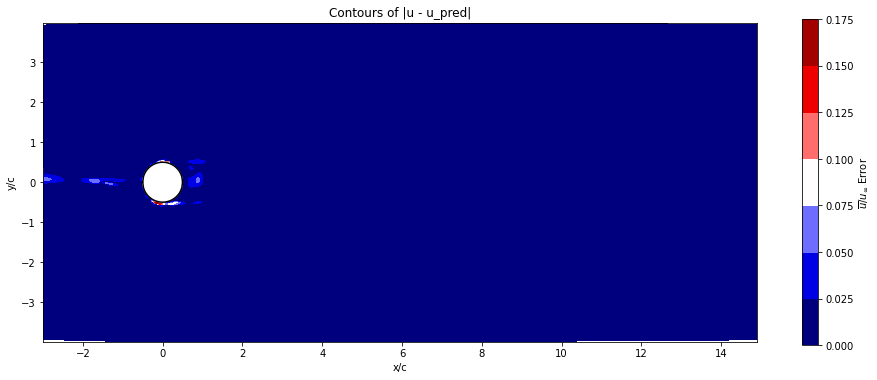

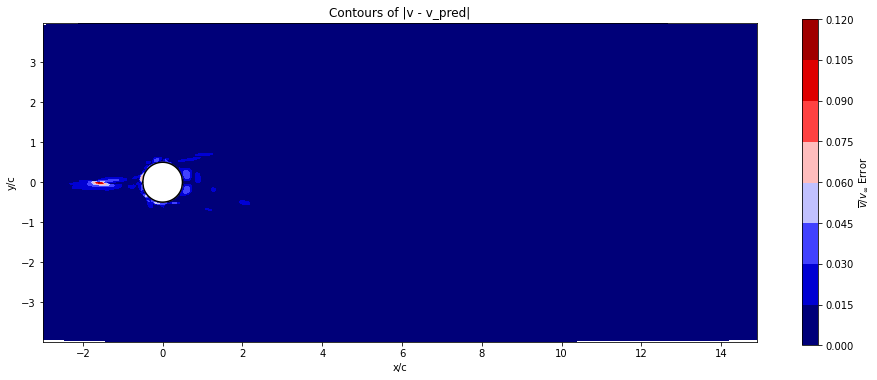

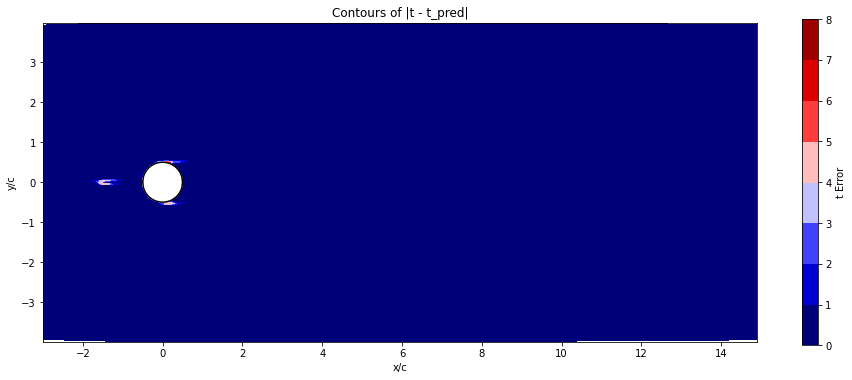

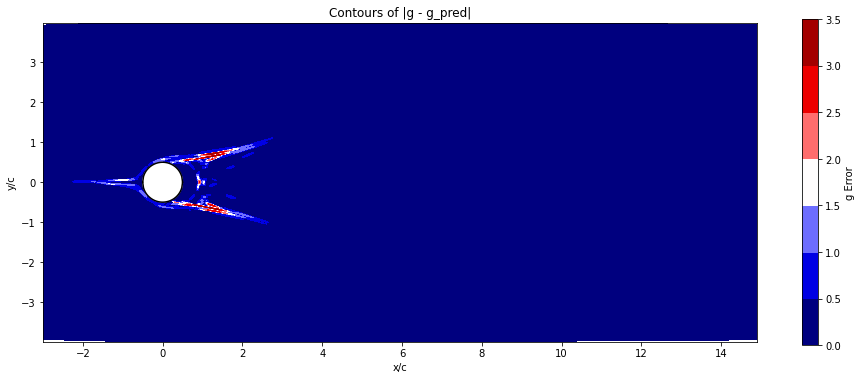

In [15]:
model.compile("adam", lr=0.001)
model.compile("L-BFGS-B")
model.restore("models/prediction-5-8000.pt")

[x_full, y_full, u_full, v_full, t_full] = \
    generate_training_points(x_cell_centroid, y_cell_centroid, u_mean_x, u_mean_y, t_mean)

[x_full, y_full, fx_full, fy_full, g_full] = \
    generate_training_points(x_cell_centroid, y_cell_centroid, div_uprime2_mean_x, div_uprime2_mean_y, g_mean)

full_points = np.hstack((x_full, y_full))

y = model.predict(full_points)
u_star = y[:, 0][:, None]
v_star = y[:, 1][:, None]
t_star = y[:, 3][:, None]
g_star = y[:, 6][:, None]

dns_x = np.array(x_full).flatten('F')
dns_y = np.array(y_full).flatten('F')
dns_u = np.array(u_full).flatten('F')
dns_v = np.array(v_full).flatten('F')
dns_t = np.array(t_full).flatten('F')
dns_g = np.array(g_full).flatten('F')

u_err = np.zeros(len(full_points))
v_err = np.zeros(len(full_points))
t_err = np.zeros(len(full_points))
g_err = np.zeros(len(full_points))

for i in range(len(full_points)):
    u_err[i] = np.abs(u_full[i] - u_star[i])
    v_err[i] = np.abs(v_full[i] - v_star[i])
    t_err[i] = np.abs(t_full[i] - t_star[i])
    g_err[i] = np.abs(g_full[i] - g_star[i])

cylinderx = np.linspace(-0.5, 0.5, 50)
cylindery = np.sqrt(0.5**2 - cylinderx**2)

cyl1 = plt.Circle((0, 0), 0.5, color='white')
cyl2 = plt.Circle((0, 0), 0.5, color='white')
cyl3 = plt.Circle((0, 0), 0.5, color='white')
cyl4 = plt.Circle((0, 0), 0.5, color='white')

plt.figure(figsize=figsize)
plt.tricontourf(dns_x, dns_y, u_err, cmap="seismic")
plt.plot(cylinderx, cylindery, color='k')
plt.plot(cylinderx, -cylindery, color='k')
plt.colorbar(shrink=0.5, label="$\\overline{u}/u_\infty$ Error")
axes = plt.gca()
axes.set_aspect(1)
axes.set_title("Contours of |u - u_pred|")
axes.set_xlabel("x/c")
axes.set_ylabel("y/c")
axes.add_patch(cyl1)
plt.show()
plt.close()

plt.figure(figsize=figsize)
plt.tricontourf(dns_x, dns_y, v_err, cmap="seismic")
plt.plot(cylinderx, cylindery, color='k')
plt.plot(cylinderx, -cylindery, color='k')
plt.colorbar(shrink=0.5, label="$\\overline{v}/v_\infty$ Error")
axes = plt.gca()
axes.set_aspect(1)
axes.set_title("Contours of |v - v_pred|")
axes.set_xlabel("x/c")
axes.set_ylabel("y/c")
axes.add_patch(cyl2)
plt.show()
plt.close()

plt.figure(figsize=figsize)
plt.tricontourf(dns_x, dns_y, t_err, cmap="seismic")
plt.plot(cylinderx, cylindery, color='k')
plt.plot(cylinderx, -cylindery, color='k')
plt.colorbar(shrink=0.5, label="t Error")
axes = plt.gca()
axes.set_aspect(1)
axes.set_title("Contours of |t - t_pred|")
axes.set_xlabel("x/c")
axes.set_ylabel("y/c")
axes.add_patch(cyl3)
plt.show()
plt.close()

plt.figure(figsize=figsize)
plt.tricontourf(dns_x, dns_y, g_err, cmap="seismic")
plt.plot(cylinderx, cylindery, color='k')
plt.plot(cylinderx, -cylindery, color='k')
plt.colorbar(shrink=0.5, label="g Error")
axes = plt.gca()
axes.set_aspect(1)
axes.set_title("Contours of |g - g_pred|")
axes.set_xlabel("x/c")
axes.set_ylabel("y/c")
axes.add_patch(cyl4)
plt.show()
plt.close()

- restore saved model from folder
- compute L2 norms of model prediction fields for all quantities compared to reference data

In [13]:
model.compile("adam", lr=0.001)
model.compile("L-BFGS-B")
model.restore("models/440-160BC-34000.pt")

[x_full, y_full, u_full, v_full, t_full] = \
    generate_training_points(x_cell_centroid, y_cell_centroid, u_mean_x, u_mean_y, t_mean)

[x_full, y_full, fx_full, fy_full, g_full] = \
    generate_training_points(x_cell_centroid, y_cell_centroid, div_uprime2_mean_x, div_uprime2_mean_y, g_mean)

full_points = np.hstack((x_full, y_full))

y = model.predict(full_points)
u_star = y[:, 0][:, None]
v_star = y[:, 1][:, None]
t_star = y[:, 3][:, None]
fx_star = y[:, 4][:, None]
fy_star = y[:, 5][:, None]
g_star = y[:, 6][:, None]

omega = 0
for i in range(len(full_points)):
    omega = omega + vol_weights[i]
    
u_sum = 0
for i in range(len(full_points)):
    u_sum = u_sum + (vol_weights[i] * (u_full[i]-u_star[i])**2)

v_sum = 0
for i in range(len(full_points)):
    v_sum = v_sum + (vol_weights[i] * (v_full[i]-v_star[i])**2)

t_sum = 0
for i in range(len(full_points)):
    t_sum = t_sum + (vol_weights[i] * (t_full[i]-t_star[i])**2)
    
fx_sum = 0
for i in range(len(full_points)):
    fx_sum = fx_sum + (vol_weights[i] * (fx_full[i]-fx_star[i])**2)
    
fy_sum = 0
for i in range(len(full_points)):
    fy_sum = fy_sum + (vol_weights[i] * (fy_full[i]-fy_star[i])**2)
    
g_sum = 0
for i in range(len(full_points)):
    g_sum = g_sum + (vol_weights[i] * (g_full[i]-g_star[i])**2)

eps2u = np.sqrt((1/omega) * u_sum)
eps2v = np.sqrt((1/omega) * v_sum)
eps2t = np.sqrt((1/omega) * t_sum)
eps2fx = np.sqrt((1/omega) * fx_sum)
eps2fy = np.sqrt((1/omega) * fy_sum)
eps2g = np.sqrt((1/omega) * g_sum)

print("eps u = " + str(eps2u))
print("eps v = " + str(eps2v))
print("eps t = " + str(eps2t))
print("eps g = " + str(eps2g))

Compiling model...
'compile' took 0.001376 s

Compiling model...
'compile' took 0.000565 s

eps u = [0.00535984]
eps v = [0.00481255]
eps t = [0.48448027]
eps g = [1.82139505]
